In [ ]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from tabulate import tabulate

get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import display, HTML


In [2]:
import json
import requests
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, GRU, BatchNormalization
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
df1 = pd.read_csv('/home/hanping/remote file/MFB/dataset/processed/text_grouped.csv')
df2 = pd.read_csv('/home/hanping/remote file/MFB/dataset/processed/btc_grouped.csv')

In [4]:
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)

df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)

In [5]:
# merge the two dataframes
df_merged = pd.merge(df1, df2, on='date', how='inner')

df_merged = df_merged.sort_values('date')
df = df_merged

target_col = 'Close'
df.head()

,compound,Close,Stochastic,ADI,EMA,MACD,RSI,OBV,ATR
date,,,,,,,,,
2021-01-01 01:00:00,0.2263,29409.99,96.295679,1229681.093,28947.88120,164.922849,62.207462,540756.7353,388.070365
2021-01-01 02:00:00,0.0000,29194.65,83.003086,1228327.545,28980.78371,170.457230,57.314228,538372.5037,385.010339
2021-01-01 03:00:00,0.0000,29278.40,85.898804,1228595.460,29020.46588,179.531664,58.675685,539833.8488,373.008172
2021-01-01 04:00:00,0.0000,29220.31,78.456428,1228685.879,29047.11176,179.961357,57.310301,537795.8020,372.479017
2021-01-01 05:00:00,0.0000,29187.01,75.583261,1229217.093,29065.76486,175.590760,56.498663,536325.8457,356.671230


In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(df2, test_size=0.2)

In [8]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1


def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())


def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [9]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [10]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [11]:
def build_hybrid_model(input_data, output_size, neurons=100, activ_func='linear',
                       dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(
        Bidirectional(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(GRU(neurons, return_sequences=False)))
    model.add(Dropout(0.2))

    model.add(Dense(units=output_size, activation=activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [12]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
hybrid_neurons = 256
epochs = 50
batch_size = 8
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [13]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [14]:
model = build_hybrid_model(
    X_train, output_size=1, neurons=hybrid_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

2024-01-17 13:09:21.729512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2024-01-17 13:09:21.730657: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-17 13:09:21.731445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild Tens

Epoch 1/50
281/281 [==============================] - 23s 32ms/step - loss: 0.0289 - val_loss: 0.0033
Epoch 2/50
281/281 [==============================] - 6s 23ms/step - loss: 0.0048 - val_loss: 8.7928e-04
Epoch 3/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 4/50
281/281 [==============================] - 6s 23ms/step - loss: 0.0022 - val_loss: 5.9451e-04
Epoch 5/50
281/281 [==============================] - 6s 23ms/step - loss: 9.5950e-04 - val_loss: 0.0010
Epoch 6/50
281/281 [==============================] - 6s 23ms/step - loss: 0.0018 - val_loss: 3.6499e-04
Epoch 7/50
281/281 [==============================] - 6s 22ms/step - loss: 4.8536e-04 - val_loss: 2.5834e-04
Epoch 8/50
281/281 [==============================] - 6s 22ms/step - loss: 6.9619e-04 - val_loss: 5.3275e-04
Epoch 9/50
281/281 [==============================] - 6s 23ms/step - loss: 5.0764e-04 - val_loss: 4.6357e-04
Epoch 10/50
281/281 [=============================

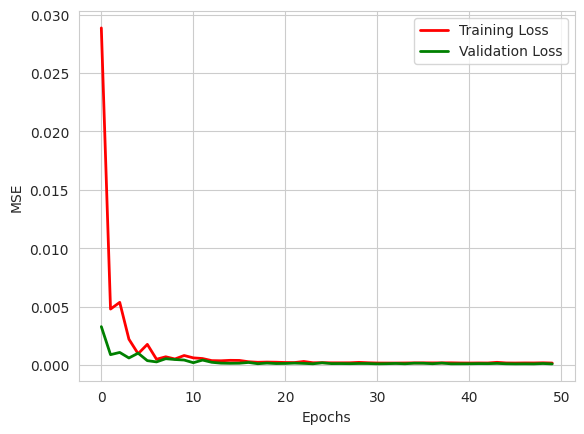

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(('Training Loss', 'Validation Loss'))
plt.show()

In [16]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 3s 10ms/step


0.006439949895748776

In [17]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(preds, y_test)
MSE

8.547638554709754e-05

In [18]:
#RMSE
import math

rmse = math.sqrt(MSE)
rmse

0.009245343992902456

In [19]:
from sklearn.metrics import r2_score

R2 = r2_score(y_test, preds)
R2

0.7296022458705036

In [20]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, preds)

2.235061502636685

In [21]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [BTC]', fontsize=20)
    ax.set_xlabel('Time', fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=14);

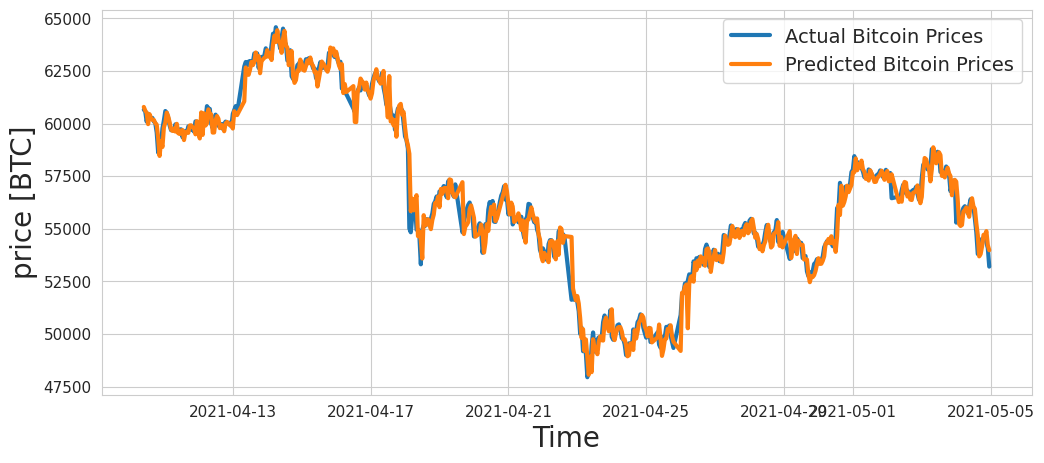

In [22]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=2)

In [23]:
o1_preds=preds

In [24]:
optimizer = 'adadelta'

In [25]:
model = build_hybrid_model(
    X_train, output_size=1, neurons=hybrid_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 24s 35ms/step - loss: 0.0033 - val_loss: 9.2760e-04
Epoch 2/50
281/281 [==============================] - 7s 26ms/step - loss: 0.0029 - val_loss: 6.9746e-04
Epoch 3/50
281/281 [==============================] - 7s 26ms/step - loss: 0.0021 - val_loss: 6.0595e-04
Epoch 4/50
281/281 [==============================] - 7s 26ms/step - loss: 0.0023 - val_loss: 5.3047e-04
Epoch 5/50
281/281 [==============================] - 7s 26ms/step - loss: 0.0021 - val_loss: 4.9504e-04
Epoch 6/50
281/281 [==============================] - 7s 24ms/step - loss: 0.0023 - val_loss: 4.7334e-04
Epoch 7/50
281/281 [==============================] - 7s 24ms/step - loss: 0.0024 - val_loss: 4.6927e-04
Epoch 8/50
281/281 [==============================] - 7s 25ms/step - loss: 0.0022 - val_loss: 4.6503e-04
Epoch 9/50
281/281 [==============================] - 7s 25ms/step - loss: 0.0023 - val_loss: 4.5142e-04
Epoch 10/50
281/281 [==============================] -

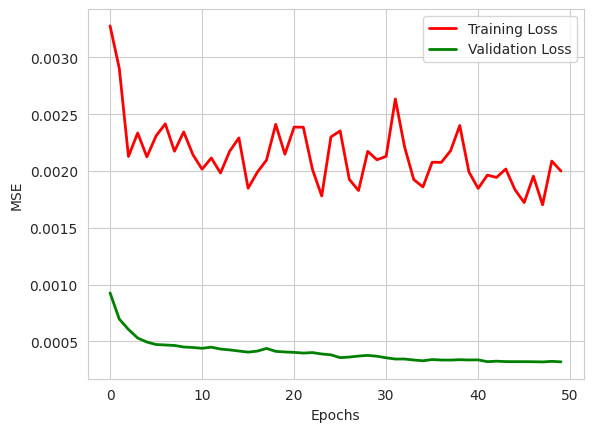

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g', linewidth=2, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(('Training Loss', 'Validation Loss'))
plt.show()

In [27]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 3s 10ms/step


0.012140956023327484

In [28]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(preds, y_test)
MSE

0.000320968696222794

In [29]:
#RMSE
import math

rmse = math.sqrt(MSE)
rmse

0.01791559924263752

In [30]:
from sklearn.metrics import r2_score

R2 = r2_score(y_test, preds)
R2

-0.015358967848437599

In [31]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, preds)

2.261666471290136

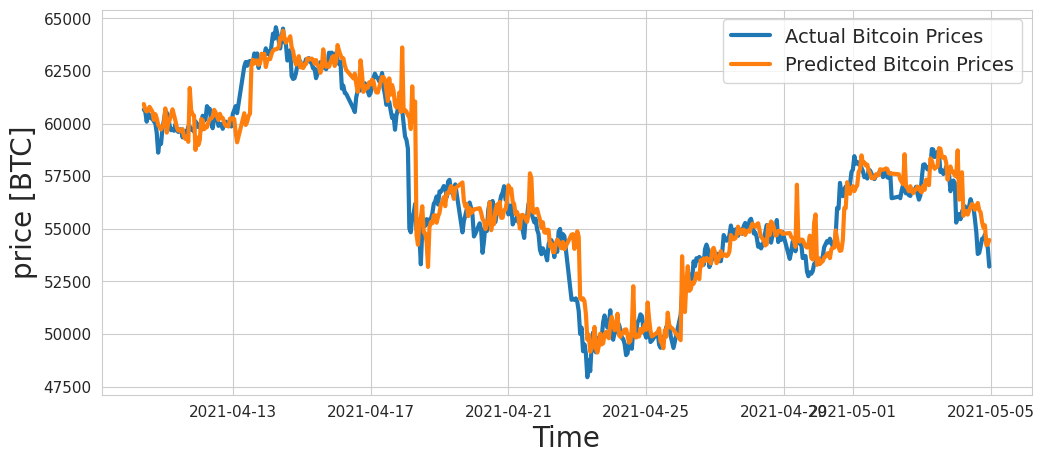

In [32]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=3)

In [33]:
o2_preds = preds

In [34]:
optimizer = 'rmsprop'

model = build_hybrid_model(
    X_train, output_size=1, neurons=hybrid_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 21s 32ms/step - loss: 0.0275 - val_loss: 9.7426e-04
Epoch 2/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 3/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 4/50
281/281 [==============================] - 6s 23ms/step - loss: 0.0022 - val_loss: 8.1869e-04
Epoch 5/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0018 - val_loss: 6.4769e-04
Epoch 6/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0012 - val_loss: 9.0514e-04
Epoch 7/50
281/281 [==============================] - 6s 22ms/step - loss: 9.0630e-04 - val_loss: 3.9760e-04
Epoch 8/50
281/281 [==============================] - 6s 22ms/step - loss: 8.7051e-04 - val_loss: 4.7598e-04
Epoch 9/50
281/281 [==============================] - 6s 22ms/step - loss: 6.5787e-04 - val_loss: 2.4739e-04
Epoch 10/50
281/281 [=============================

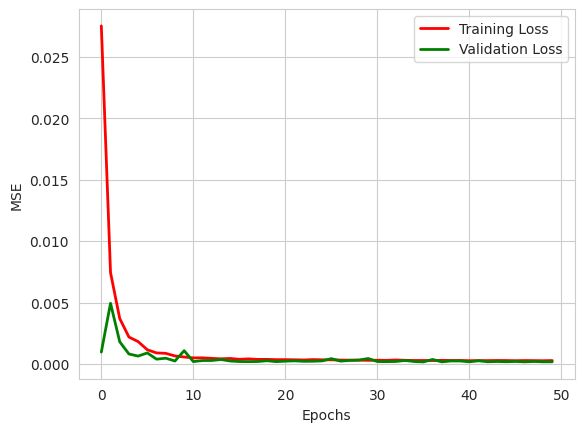

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g', linewidth=2, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(('Training Loss', 'Validation Loss'))
plt.show()

In [36]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)


18/18 [==============================] - 3s 10ms/step


0.009263442987715727

In [37]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(preds, y_test)
MSE

0.00018279118185115048

In [38]:
#RMSE
import math

rmse = math.sqrt(MSE)
rmse

0.013520028914582633

In [39]:
from sklearn.metrics import r2_score

R2 = r2_score(y_test, preds)
R2

0.4217546199354264

In [40]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, preds)

5.045384223481505

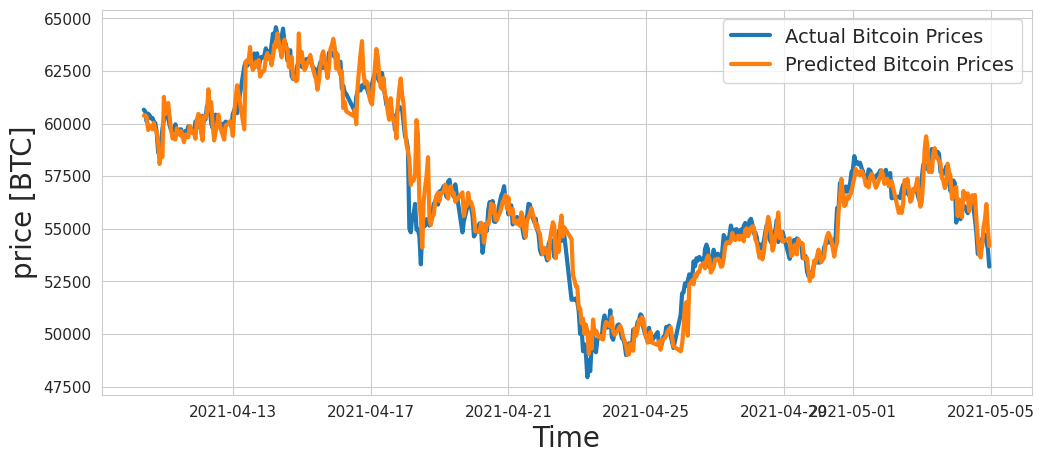

In [41]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=3)

In [42]:
o3_preds = preds

In [43]:
optimizer = 'adagrad'

model = build_hybrid_model(
    X_train, output_size=1, neurons=hybrid_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 21s 30ms/step - loss: 0.0034 - val_loss: 3.8670e-04
Epoch 2/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0016 - val_loss: 2.7219e-04
Epoch 3/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0016 - val_loss: 2.5466e-04
Epoch 4/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0016 - val_loss: 4.2427e-04
Epoch 5/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0019 - val_loss: 2.8799e-04
Epoch 6/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0023 - val_loss: 2.7634e-04
Epoch 7/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0017 - val_loss: 2.9129e-04
Epoch 8/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0021 - val_loss: 2.4632e-04
Epoch 9/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0018 - val_loss: 3.1223e-04
Epoch 10/50
281/281 [==============================] -

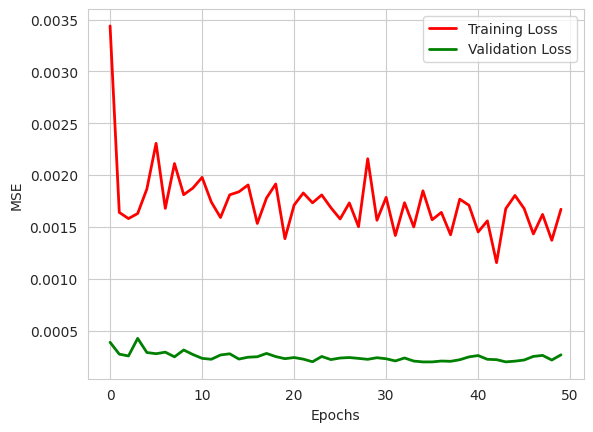

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g', linewidth=2, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(('Training Loss', 'Validation Loss'))
plt.show()

In [45]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 3s 10ms/step


0.010288937965593093

In [46]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(preds, y_test)
MSE

0.000265751256808164

In [47]:
#RMSE
import math

rmse = math.sqrt(MSE)
rmse

0.016301878934900847

In [48]:
from sklearn.metrics import r2_score

R2 = r2_score(y_test, preds)
R2

0.15931701442353963

In [49]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, preds)

3.2377939602895656

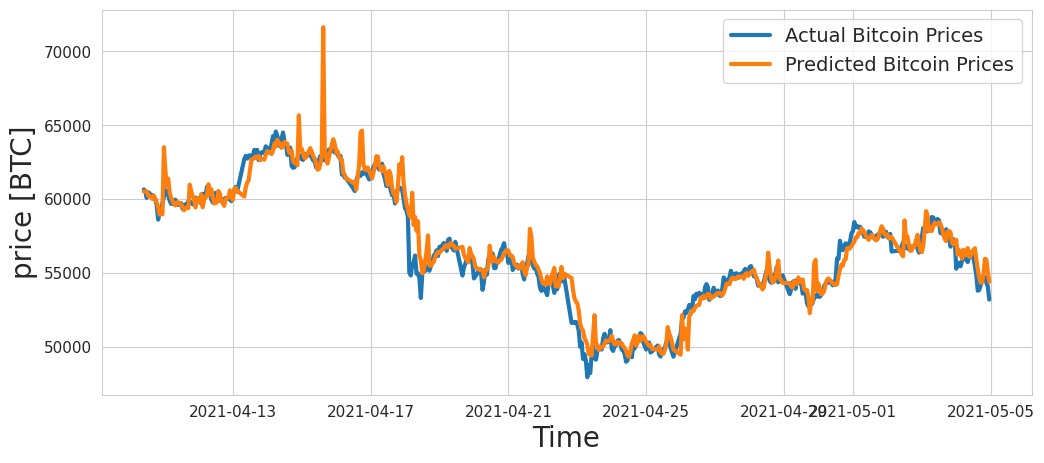

In [50]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=3)

In [51]:
o4_preds = preds

In [52]:
optimizer = 'sgd'
model = build_hybrid_model(
    X_train, output_size=1, neurons=hybrid_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 22s 30ms/step - loss: 0.0031 - val_loss: 6.7581e-04
Epoch 2/50
281/281 [==============================] - 6s 21ms/step - loss: 0.0019 - val_loss: 3.3320e-04
Epoch 3/50
281/281 [==============================] - 6s 21ms/step - loss: 0.0024 - val_loss: 5.9031e-04
Epoch 4/50
281/281 [==============================] - 6s 21ms/step - loss: 0.0021 - val_loss: 5.4033e-04
Epoch 5/50
281/281 [==============================] - 6s 21ms/step - loss: 0.0018 - val_loss: 2.9724e-04
Epoch 6/50
281/281 [==============================] - 6s 21ms/step - loss: 0.0017 - val_loss: 5.3334e-04
Epoch 7/50
281/281 [==============================] - 6s 21ms/step - loss: 0.0020 - val_loss: 3.3678e-04
Epoch 8/50
281/281 [==============================] - 6s 21ms/step - loss: 0.0019 - val_loss: 5.8893e-04
Epoch 9/50
281/281 [==============================] - 6s 22ms/step - loss: 0.0017 - val_loss: 2.7376e-04
Epoch 10/50
281/281 [==============================] -

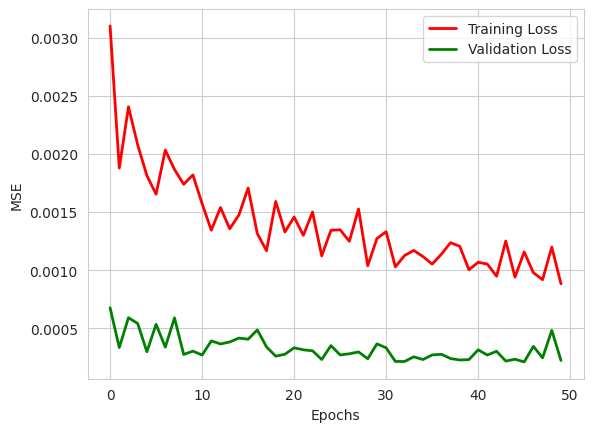

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g', linewidth=2, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(('Training Loss', 'Validation Loss'))
plt.show()

In [54]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 3s 11ms/step


0.010284088705843977

In [55]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(preds, y_test)
MSE

0.00022210450272137886

In [56]:
#RMSE
import math

rmse = math.sqrt(MSE)
rmse

0.014903170894859217

In [57]:
from sklearn.metrics import r2_score

R2 = r2_score(y_test, preds)
R2

0.29739005301273236

In [58]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, preds)

5.619509568440071

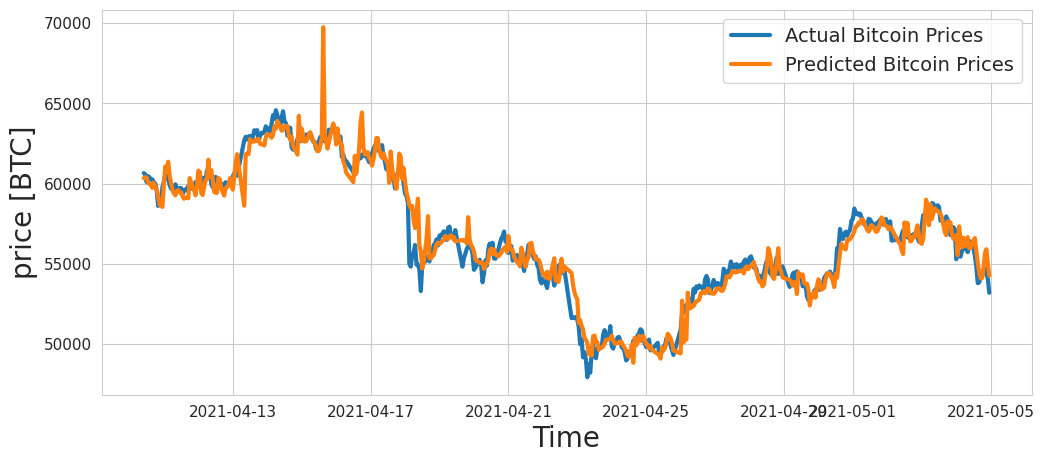

In [59]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=3)

In [60]:
o5_preds = preds

In [73]:
def line_plot2(line1, line2, line3, line4, line5, line6, label1=None, label2=None, label3=None, label4=None,
               label5=None, label6=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(15, 6))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.plot(line4, label=label4, linewidth=lw)
    ax.plot(line5, label=label5, linewidth=lw)
    ax.plot(line6, label=label6, linewidth=lw)
    ax.set_ylabel('price [BTC]', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.tick_params(labelsize=11)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=11)

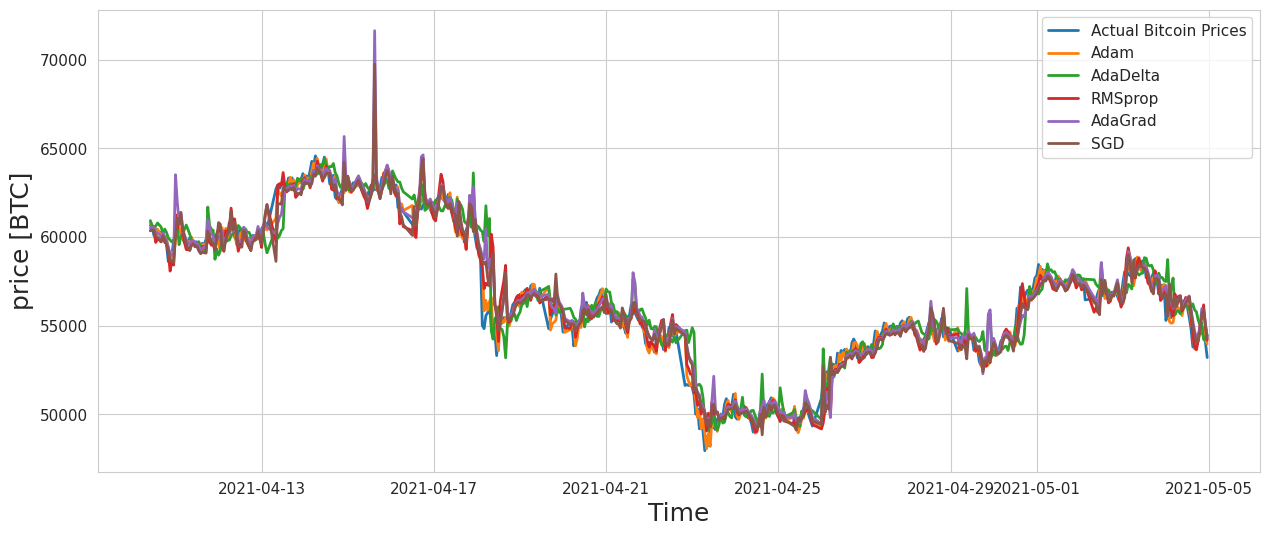

In [74]:
line_plot2(targets, o1_preds, o2_preds, o3_preds, o4_preds, o5_preds, 'Actual Bitcoin Prices',
           'Adam', 'AdaDelta', 'RMSprop', 'AdaGrad','SGD', lw=2)